### TODO:

- Run every method on the same test set and compare
- to the best model add generated features (user age and hour of accident)
- run SVM and KNN on dataset obtrained from downsampling - on LR tested that it gives the same results as big one
- try to compare auc curves - probably these will overlap fully for all created models but we can try

### Preparation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tools.tools import add_constant

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import pickle


pd.set_option("display.max_columns",200)

def print_value_counts(df):
    for i in df.columns:
        print(f'column: {i}')
        display(df[i].value_counts())
        print()

In [2]:
x_train = pd.read_pickle('data/x_train.pkl')
y_train = pd.read_pickle('data/y_train.pkl')

x_test = pd.read_pickle('data/x_test.pkl')
y_test = pd.read_pickle('data/y_test.pkl')

minfos_df = pd.read_pickle('data/minfos_df.pkl')

## Modeling

### GLM with adding features from mutual info

Running kfold cross validation, with recursive feature selection. Features are added one by one, ordered by mutual info. Using caching here as it's running for long - just run next cell.

In [3]:
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_squared_error
# import random
# kf = KFold(n_splits=3, shuffle=True, random_state=random.randint(0,10000))

# scores = []

# for no_features_to_include in range(1,30):
#     if no_features_to_include % 5 == 1:
#         # trick to control number of features selected 
#         print('running ', no_features_to_include)
#     features = list(minfos_df.head(no_features_to_include).column)
#     r2_train = []
#     r2_test = []

#     for train, test in kf.split(x_train.index.values):
#         reg = LogisticRegression()
#         reg.fit(x_train.iloc[train][features], y_train.iloc[train]['y'])
        
#         predsTrain = reg.predict_proba(x_train.iloc[train][features])
#         preds = reg.predict_proba(x_train.iloc[test][features])

#         r2_test.append(roc_auc_score(y_train.iloc[test].y, preds[:,1]))
#         r2_train.append(roc_auc_score(y_train.iloc[train].y, predsTrain[:,1]))

#     a = (no_features_to_include, np.mean(r2_test), np.mean(r2_train))
#     scores.append(a)    
# #     print(a)
# roc_scores_lr = pd.DataFrame(scores, columns = ['no_features', 'test', 'train'])
# roc_scores_lr.to_pickle('models_cache/roc_scores_lr_from_minfo.pkl')

Note: above cell is cached and read below, no nneed to re-run

In [4]:
roc_scores_lr = pd.read_pickle('models_cache/roc_scores_lr_from_minfo.pkl')

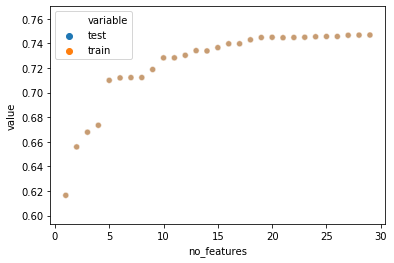

In [5]:
sns.scatterplot(x = 'no_features', y= 'value', hue = 'variable', alpha = 0.5, data = pd.melt(roc_scores_lr, id_vars = 'no_features'))

The above plot shows that train and test scores overlap almost fully - that means that logistic regression is very resilient to overfitting as it didn't occur at all in this case

Best value of AUC is around 0.74. After adding 20 features the outcome is not changing significantly. Now I'm fitting model with that amount of features to obtain true outcome on the held-out test set. 

In [6]:
features = list(minfos_df.head(20).column)
reg = LogisticRegression()
reg.fit(x_train[features], y_train['y'])

predsTrain = reg.predict_proba(x_train[features])
predsTest = reg.predict_proba(x_test[features])

print("AUC for train set " , roc_auc_score(y_train.y, predsTrain[:,1]))
print("AUC for test set " , roc_auc_score(y_test.y, predsTest[:,1]))

AUC for train set  0.7449061773364156
AUC for test set  0.7138230627089149


Value of AUC for test set is 0.714 - drop from train set is really small

### GLM model with all features

In [7]:
mod = sm.GLM(y_train['y'],x_train,family = sm.families.Binomial())
res= mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:               778601
Model:                            GLM   Df Residuals:                   778548
Model Family:                Binomial   Df Model:                           52
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.7755e+05
Date:                Sat, 06 Jun 2020   Deviance:                   7.5509e+05
Time:                        22:21:24   Pearson chi2:                 7.83e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
d_lighting_Night with public lighting on                          0.1898      0.009     22.300      0.000       0.173       0.206
d_lighting_Night without public lighting                          0.3233      0.011     30.379      0.000       0.302       0.344
d_lighting_Twilight or dawn                                       0.1165      0.012      9.682      0.000       0.093       0.140
d_localization_Out of agglomeration                               0.7703      0.008     95.881      0.000       0.755       0.786
d_intersection_type_Intersection in T                            -0.0772      0.015     -5.061      0.000      -0.107      -0.047
d_intersection_type_Intersection in X                            -0.1482      0.014    -10.340      0.000      -0.176      -0.120
d_intersection_type_Out of intersection                           0.1624      0.012     13.793      0.000       0.139       0.185
d_weather_Heavy rain                                             -0.0826      0.023     -3.619      0.000      -0.127      -0.038
d_weather_Light rain                                             -0.2482      0.016    -15.888      0.000      -0.279      -0.218
d_weather_Normal                                                 -0.1275      0.012    -10.635      0.000      -0.151      -0.104
d_collision_type_Other collision                                 -0.1250      0.630     -0.198      0.843      -1.359       1.109
d_collision_type_Three or more vehicles - multiple collisions    -0.6133      0.630     -0.974      0.330      -1.848       0.621
d_collision_type_Three vehicles and more - in chain              -1.2402      0.630     -1.968      0.049      -2.476      -0.005
d_collision_type_Two vehicles - by the side                      -0.2257      0.630     -0.358      0.720      -1.460       1.009
d_collision_type_Two vehicles - from the rear                    -0.6120      0.630     -0.972      0.331      -1.846       0.623
d_collision_type_Two vehicles - frontal                           0.1144      0.630      0.182      0.856      -1.120       1.349
d_collision_type_Without collision                                0.2334      0.630      0.371      0.711      -1.001       1.468
d_road_category_Departmental Road                                 0.6558      0.007     88.362      0.000       0.641       0.670
d_road_category_Highway                                          -0.0252      0.015     -1.634      0.102      -0.055       0.005
d_road_category_National Road                                     0.3862      0.011     33.653      0.000       0.364       0.409
d_road_regime_NA                                                 -0.1335      0.013    -10.07

In [8]:
prob = res.predict()
preds = np.array([1 if x<0.5 else 0 for x in prob])
pd.crosstab((y_train['y']),preds)

col_0,0,1
y,,
0,32964,547015
1,56227,142395


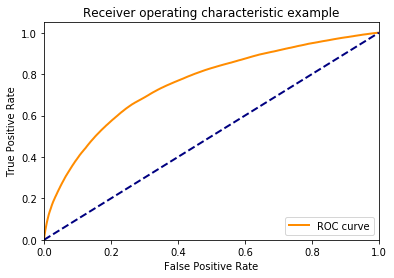

In [9]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_train.y, res.predict())
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
# plt.show()

### Modeling with SVM - small set, 20 best features from mutual info

As the dataset is huge - using SVM with other kernel than linear is out of question. Running it on 2 features only, with radial kernel, would take >10 minutes. That is why I have used linear kernel only. Linear kernel is still infeasible to run on the full dataset. Main train dataset has ~7 mln observations, fitting linear svm becomes infeasible at 100 000 obs - at 10 000 the speed is acceptable.

In [10]:
from sklearn.svm import SVC

Reducing train set size - the same random state in x and y gives proper observations

In [11]:
x_train_small = x_train.sample(n = 10000, random_state = 42)
y_train_small = y_train.sample(n = 10000, random_state = 42)

Running SVM on default parameters, best 20 features obtained before are selected.

In [12]:
features = list(minfos_df.head(20).column)
reg = SVC(kernel = 'rbf', probability = True)
reg.fit(x_train_small[features], y_train_small['y'])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [13]:
# predsTest = reg.predict_proba(x_test[features])

# print("AUC for train set " , roc_auc_score(y_train.y, predsTrain[:,1]))
# print("AUC for test set " , roc_auc_score(y_test.y, predsTest[:,1]))

Above takes very long to run - AUC on test set was 0.625, lower than the best model from logistic regression (0.715)

SVM with 20 features - finding the best C

Trying to find the best c value on the smaller train set with 10 000 observations - obtained above. Number of features is set at 20, as this was correct number shown by Logistic Regression. Again, the kernel is linear.

In [14]:
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_squared_error
# import random
# kf = KFold(n_splits=3, shuffle=True, random_state=random.randint(0,10000))

# scores = []
# cs = [0.1, 0.5, 1, 1.5, 2, 10]
# no_features_to_include = 20
# features = list(minfos_df.head(no_features_to_include).column)

# for c in cs:
#     print('running for c: ', c)

#     r2_train = []
#     r2_test = []

#     for train, test in kf.split(x_train_small.index.values):
#         reg = SVC(kernel = 'linear', probability = True, C = c)
#         reg.fit(x_train_small.iloc[train][features], y_train_small.iloc[train]['y'])
        
#         predsTrain = reg.predict_proba(x_train_small.iloc[train][features])
#         preds = reg.predict_proba(x_train_small.iloc[test][features])

#         r2_test.append(roc_auc_score(y_train_small.iloc[test].y, preds[:,1]))
#         r2_train.append(roc_auc_score(y_train_small.iloc[train].y, predsTrain[:,1]))

#     a = (c, np.mean(r2_test), np.mean(r2_train))
#     scores.append(a)  

# #     print(a)
# roc_scores_svm = pd.DataFrame(scores, columns = ['c', 'test', 'train'])
# roc_scores_svm.to_pickle('models_cache/roc_scores_svm_from_minfo.pkl')

Note: above cell is cached and read below, no nneed to re-run

In [15]:
roc_scores_svm = pd.read_pickle('models_cache/roc_scores_svm_from_minfo.pkl')

In [16]:
roc_scores_svm

,no_features,test,train
0,0.1,0.677838,0.686063
1,0.5,0.673228,0.680600
2,1.0,0.682514,0.691938
3,1.5,0.697586,0.700556
4,2.0,0.699163,0.703936
5,10.0,0.696553,0.703841


Performance did not improve much - best value was for c = 1.5, and result obtained for test set from cross validation was 0.699. Using the same procedure, fitting SVM with rbf kernel.

In [17]:
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_squared_error
# import random
# kf = KFold(n_splits=3, shuffle=True, random_state=random.randint(0,10000))

# scores = []
# cs = [0.1, 0.5, 1, 1.5, 2, 10]
# no_features_to_include = 20
# features = list(minfos_df.head(no_features_to_include).column)

# for c in cs:
#     print('running for c: ', c)

#     r2_train = []
#     r2_test = []

#     for train, test in kf.split(x_train_small.index.values):
#         reg = SVC(kernel = 'rbf', probability = True, C = c)
#         reg.fit(x_train_small.iloc[train][features], y_train_small.iloc[train]['y'])
        
#         predsTrain = reg.predict_proba(x_train_small.iloc[train][features])
#         preds = reg.predict_proba(x_train_small.iloc[test][features])

#         r2_test.append(roc_auc_score(y_train_small.iloc[test].y, preds[:,1]))
#         r2_train.append(roc_auc_score(y_train_small.iloc[train].y, predsTrain[:,1]))

#     a = (c, np.mean(r2_test), np.mean(r2_train))
#     scores.append(a)  

# #     print(a)
# roc_scores_svm_rbf = pd.DataFrame(scores, columns = ['no_features', 'test', 'train'])
# roc_scores_svm_rbf.to_pickle('models_cache/roc_scores_svm_rbf_from_minfo.pkl')

Note: above cell is cached and read below, no nneed to re-run

In [18]:
roc_scores_svm_rbf = pd.read_pickle('models_cache/roc_scores_svm_rbf_from_minfo.pkl')

In [19]:
roc_scores_svm_rbf

,no_features,test,train
0,0.1,0.680796,0.700328
1,0.5,0.675718,0.705103
2,1.0,0.678240,0.712834
3,1.5,0.665435,0.709508
4,2.0,0.656149,0.704020
5,10.0,0.631586,0.709276


Performance using radial kernel got even worse than using linear kernel.

### SVM with 20 features using Stochastic Gradient Descent - finding the best C

Using SGDClassifier with 'hinge' loss, it is equivalent to running standard SVM classifier, but allows for parallel computing. This allows for using full set for training.

In SGD there is parameter alpha performing the regularization. Its relation to c in SVM function is C_svc * n_samples = 1 / alpha_sgd

alpha_sgd = 1 / (C_svc * n_samples)

https://stats.stackexchange.com/questions/216095/how-does-alpha-relate-to-c-in-scikit-learns-sgdclassifier


In [20]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

In [21]:
features = list(minfos_df.head(20).column)
reg = SGDClassifier(n_jobs = -1)
reg.fit(x_train[features], y_train['y'])

calibrator = CalibratedClassifierCV(reg, cv='prefit')
calib_model =calibrator.fit(x_train[features], y_train['y'])

In [22]:
predsTest = calib_model.predict_proba(x_test[features])
# print("AUC for train set " , roc_auc_score(y_train.y, predsTrain[:,1]))
print("AUC for test set " , roc_auc_score(y_test.y, predsTest[:,1]))

AUC for test set  0.6828794940439905


In [23]:
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_squared_error
# import random
# kf = KFold(n_splits=3, shuffle=True, random_state=random.randint(0,10000))

# scores = []
# cs = [0.1, 0.5, 1, 1.5, 2, 10]
# no_features_to_include = 20
# features = list(minfos_df.head(no_features_to_include).column)

# for c in cs:
#     print('running for c: ', c)

#     r2_train = []
#     r2_test = []

#     for train, test in kf.split(x_train.index.values):
#         n_samples = x_train.iloc[train][features].shape[0]
#         alpha_sgd = 1 / (c * n_samples)
# #         print('computed alpha:', alpha_sgd)
        
#         reg = SGDClassifier(n_jobs = -1, alpha = alpha_sgd)
#         reg.fit(x_train.iloc[train][features], y_train.iloc[train]['y'])
        
#         calibrator = CalibratedClassifierCV(reg, cv='prefit')
#         calib_model =calibrator.fit(x_train.iloc[train][features], y_train.iloc[train]['y'])
        
#         predsTrain = calib_model.predict_proba(x_train.iloc[train][features])
#         preds = calib_model.predict_proba(x_train.iloc[test][features])
        
#         r2_test.append(roc_auc_score(y_train.iloc[test].y, preds[:,1]))
#         r2_train.append(roc_auc_score(y_train.iloc[train].y, predsTrain[:,1]))

#     a = (c, np.mean(r2_test), np.mean(r2_train))
#     scores.append(a)  

# #     print(a)
# roc_scores_sgd = pd.DataFrame(scores, columns = ['c', 'test', 'train'])
# roc_scores_sgd.to_pickle('models_cache/roc_scores_sgd_from_minfo.pkl')

In [24]:
roc_scores_sgd = pd.read_pickle('models_cache/roc_scores_sgd_from_minfo.pkl')

In [25]:
roc_scores_sgd

,c,test,train
0,0.1,0.732488,0.732324
1,0.5,0.734136,0.734158
2,1.0,0.708720,0.709347
3,1.5,0.733063,0.732837
4,2.0,0.735335,0.735096
5,10.0,0.698826,0.699061


Best alpha is 2.0. Now fitting to the full dataset and checking GOF for test set.

In [26]:
features = list(minfos_df.head(20).column)
reg = SGDClassifier(n_jobs = -1,alpha = 1/(1.5*x_train.shape[0]))
reg.fit(x_train[features], y_train['y'])

calibrator = CalibratedClassifierCV(reg, cv='prefit')
calib_model =calibrator.fit(x_train[features], y_train['y'])

In [27]:
predsTrain = calib_model.predict_proba(x_train[features])
predsTest = calib_model.predict_proba(x_test[features])
print("AUC for train set " , roc_auc_score(y_train.y, predsTrain[:,1]))
print("AUC for test set " , roc_auc_score(y_test.y, predsTest[:,1]))

AUC for train set  0.7352921547320131
AUC for test set  0.7071204373612293


Not much improvement over the LR

### Feature generation

#### Using features that looked promising from EDA

In [28]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
%matplotlib inline
cols_to_log = [
 'd_lighting_Night without public lighting',
 'd_lighting_Twilight or dawn',
 'd_localization_Out of agglomeration',
 'd_intersection_type_Out of intersection',
 'd_weather_Normal',
 'd_collision_type_Other collision',
 'd_collision_type_Two vehicles - frontal',
 'd_collision_type_Without collision',
 'd_road_category_Departmental Road',
 'd_road_regime_One way',
 'd_road_regime_Separated carriageways',
 'd_reserved_lane_NA',
 'd_road_gradient_NA',
 'd_road_plan_NA',
 'd_road_plan_Straight part',
 'd_road_condition_normal',
 'd_road_condition_wet',
 'd_accident_situation_On the verge',
 'd_place_in_car_1',
 'd_place_in_car_NA',
 'd_user_type_Pedestrian',
 'd_equipment_used_no',
 'd_pedestrian_action_not specified or not applicable',
 'd_pedestrian_alone_NA',
 'hour',
 'user_age'
 ]

features = cols_to_log
reg = LogisticRegression()
reg.fit(x_train[features], y_train['y'])

predsTrain = reg.predict_proba(x_train[features])
predsTest = reg.predict_proba(x_test[features])

print("AUC for train set " , roc_auc_score(y_train.y, predsTrain[:,1]))
print("AUC for test set " , roc_auc_score(y_test.y, predsTest[:,1]))


/home/kamo1997/miniconda3/envs/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC for train set  0.7420392519739142
AUC for test set  0.7095722400354767


Value of AUC using features selected by hand is a little bit smaller than using 20 best features from mutual info. Now trying if binning continuous variables will help, as it looked promising in the EDA part.

In [29]:
features = list(minfos_df.head(20).column) + ['hour', 'user_age']
reg = LogisticRegression()
reg.fit(x_train[features], y_train['y'])

predsTrain = reg.predict_proba(x_train[features])
predsTest = reg.predict_proba(x_test[features])

print("AUC for train set " , roc_auc_score(y_train.y, predsTrain[:,1]))
print("AUC for test set " , roc_auc_score(y_test.y, predsTest[:,1]))


/home/kamo1997/miniconda3/envs/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC for train set  0.7446775037381534
AUC for test set  0.7137410529079219


#### Binning categorical variables - user age

In [30]:
temp_age = pd.concat([x_train[['user_age']], y_train['y']], axis=1)

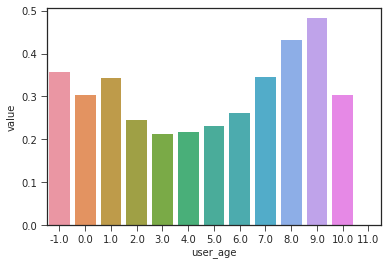

In [31]:
a = pd.crosstab(temp_age['user_age']//10, columns=temp_age['y'], 
                 normalize='index').reset_index()
b = pd.melt(a, id_vars=['user_age'], value_vars=[0, 1])

b

sns.barplot(x = 'user_age', y = 'value', data = b.query('y==1'))

The plot above presents percentage of people at given age who were killed. As can be seen there is some regularity - very young and very old people are more likely to die. 

#### Benchmark

In [32]:
features = list(minfos_df.head(20).column) + ['user_age']

x_train_age = x_train.copy()
x_train_age['user_age'] = x_train_age['user_age']

x_test_age = x_test.copy()
x_test_age['user_age'] = x_test['user_age']

reg = LogisticRegression()
reg.fit(x_train_age[features], y_train['y'])

predsTrain = reg.predict_proba(x_train_age[features])
predsTest = reg.predict_proba(x_test_age[features])

print("AUC for train set " , roc_auc_score(y_train.y, predsTrain[:,1]))
print("AUC for test set " , roc_auc_score(y_test.y, predsTest[:,1]))


/home/kamo1997/miniconda3/envs/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC for train set  0.7442413463574252
AUC for test set  0.7135150656321438


#### Finding the best bin width

In [33]:
features = list(minfos_df.head(20).column) + ['user_age']

for bin_width in [10, 15, 20, 25, 30]:
    print('testing bin width of:', bin_width)
    x_train_age = x_train[features].copy()
    x_train_age['user_age'] = x_train_age['user_age']//bin_width
    x_train_age = pd.concat([x_train_age.drop('user_age', axis = 1), 
                             pd.get_dummies(x_train_age['user_age'],drop_first = 1)], axis = 1)

    x_test_age = x_test[features].copy()
    x_test_age['user_age'] = x_test_age['user_age']//bin_width
    x_test_age = pd.concat([x_test_age.drop('user_age', axis = 1), 
                             pd.get_dummies(x_test_age['user_age'],drop_first = 1)], axis = 1)


    reg = LogisticRegression()
    reg.fit(x_train_age, y_train['y'])

    predsTrain = reg.predict_proba(x_train_age)
    predsTest = reg.predict_proba(x_test_age)

    print("AUC for train set " , roc_auc_score(y_train.y, predsTrain[:,1]))
    print("AUC for test set " , roc_auc_score(y_test.y, predsTest[:,1]))



testing bin width of: 10


/home/kamo1997/miniconda3/envs/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC for train set  0.7509616285171397
AUC for test set  0.7199356590696651
testing bin width of: 15
AUC for train set  0.7482501910008074
AUC for test set  0.7180935481748916
testing bin width of: 20
AUC for train set  0.7499088677963751
AUC for test set  0.717719662931461
testing bin width of: 25
AUC for train set  0.7488322798726931
AUC for test set  0.7178856545344641
testing bin width of: 30
AUC for train set  0.7473060754110781
AUC for test set  0.7166482122862552


Small improvement!

Benchmark:

- AUC for train set  0.7436704000408136
- AUC for test set  0.7163762566270527



Adding age variable with bin width of 10 really gave an improvement (0.0003 on AUC but still) 

#### Feature generation - hour of accident

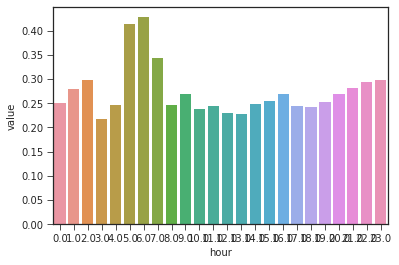

In [34]:
temp_h = pd.concat([x_train[['hour']], y_train['y']], axis=1)
a = pd.crosstab(temp_h['hour'], columns=temp_age['y'], 
                 normalize='index').reset_index()
b = pd.melt(a, id_vars=['hour'], value_vars=[0, 1])

b

sns.barplot(x = 'hour', y = 'value', data = b.query('y==1'))

Worst hours are 5, 6 and 7.

#### Putting all hours as dummies

In [35]:
features = list(minfos_df.head(20).column) + ['hour']


x_train_h = x_train[features].copy()
x_train_h['hour'] = x_train_h['hour']
x_train_h = pd.concat([x_train_h.drop('hour', axis = 1), 
                         pd.get_dummies(x_train_h['hour'],drop_first = 1)], axis = 1)

x_test_h = x_test[features].copy()
x_test_h['hour'] = x_test_h['hour']
x_test_h = pd.concat([x_test_h.drop('hour', axis = 1), 
                         pd.get_dummies(x_test_h['hour'],drop_first = 1)], axis = 1)

reg = LogisticRegression()
reg.fit(x_train_h, y_train['y'])

predsTrain = reg.predict_proba(x_train_h)
predsTest = reg.predict_proba(x_test_h)

print("AUC for train set " , roc_auc_score(y_train.y, predsTrain[:,1]))
print("AUC for test set " , roc_auc_score(y_test.y, predsTest[:,1]))

/home/kamo1997/miniconda3/envs/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC for train set  0.746051283808023
AUC for test set  0.7144940120733068


Even with all hours present the results are better than without them!

#### Dropping irrelevant hours (judging from the plot above)

In [36]:
features = list(minfos_df.head(20).column) + ['hour']
hours_to_drop = [5,6]


x_train_h = x_train[features].copy()
x_train_h['hour'] = x_train_h['hour']
x_train_h = pd.concat([x_train_h.drop('hour', axis = 1), 
                         pd.get_dummies(x_train_h['hour'],drop_first = 1)], axis = 1)
x_train_h.drop(hours_to_drop, axis = 1, inplace = True)

x_test_h = x_test[features].copy()
x_test_h['hour'] = x_test_h['hour']
x_test_h = pd.concat([x_test_h.drop('hour', axis = 1), 
                         pd.get_dummies(x_test_h['hour'],drop_first = 1)], axis = 1)
x_test_h.drop(hours_to_drop, axis = 1, inplace = True)

reg = LogisticRegression()
reg.fit(x_train_h, y_train['y'])

predsTrain = reg.predict_proba(x_train_h)
predsTest = reg.predict_proba(x_test_h)

print("AUC for train set " , roc_auc_score(y_train.y, predsTrain[:,1]))
print("AUC for test set " , roc_auc_score(y_test.y, predsTest[:,1]))

/home/kamo1997/miniconda3/envs/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC for train set  0.7459877982823887
AUC for test set  0.7144947871141105


### Imbalance methods

In [37]:
x_train.shape

(778601, 53)

The dataset is slightly imbalanced. Only 23% of people involved in the accidents were seriously injured or killed. That is why we have decided to include methods for fighting this imbalance. The dataset is very big - with around 80 000 observations in train set. That is why undersampling seems a good choice. It will be also faster to test more possible combinations.

#### Benchmark

In [38]:
features = list(minfos_df.head(20).column)
reg = LogisticRegression()
reg.fit(x_train[features], y_train['y'])

predsTrain = reg.predict_proba(x_train[features])
predsTest = reg.predict_proba(x_test[features])

print("AUC for train set " , roc_auc_score(y_train.y, predsTrain[:,1]))
print("AUC for test set " , roc_auc_score(y_test.y, predsTest[:,1]))

AUC for train set  0.7449061773364156
AUC for test set  0.7138230627089149


#### Downsampling to obtain 50/50 distribution of 0s nad 1s

In [39]:
y_train.y.value_counts()

0    579979
1    198622
Name: y, dtype: int64

For perfect imbalance we need to drop 381150 instances with y=0.

In [40]:
from random import shuffle
trainIndex0 = list(y_train.query("y==0").index.values)
shuffle(trainIndex0)

In [41]:
x_train_u = x_train.drop(trainIndex0[0:381150])
y_train_u = y_train.drop(trainIndex0[0:381150])

In [42]:
print(y_train_u.y.value_counts())
print(x_train_u.shape)

0    198829
1    198622
Name: y, dtype: int64
(397451, 53)


In [43]:
features_u = list(minfos_df.head(20).column)
reg_u = LogisticRegression()
reg_u.fit(x_train_u[features_u], y_train_u['y'])

predsTrain = reg_u.predict_proba(x_train_u[features_u])
predsTest = reg_u.predict_proba(x_test[features_u])

print("AUC for train set " , roc_auc_score(y_train_u.y, predsTrain[:,1]))
print("AUC for test set " , roc_auc_score(y_test.y, predsTest[:,1]))

AUC for train set  0.745048488167891
AUC for test set  0.7141584026750909


Downsampling improved the results on the test set by small amount. 

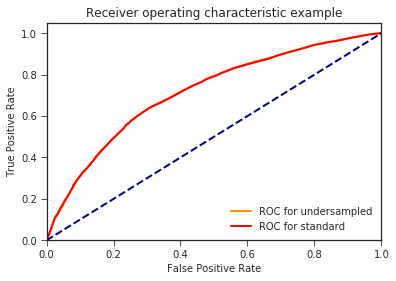

In [44]:
from sklearn.metrics import roc_curve
fpr_u, tpr_u, _ = roc_curve(y_test.y, reg_u.predict_proba(x_test[features_u])[:,1])
fpr, tpr, _ = roc_curve(y_test.y, reg.predict_proba(x_test[features])[:,1])
plt.figure()
lw = 2
plt.plot(fpr_u, tpr_u, color='darkorange',
         lw=lw, label='ROC for undersampled')
plt.plot(fpr, tpr, color='red',
         lw=lw, label='ROC for standard')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
# plt.show()

ROC with and without resampling are essentially the same.

Note: 95918 observations 50/50 are enought to create the same accuracy.

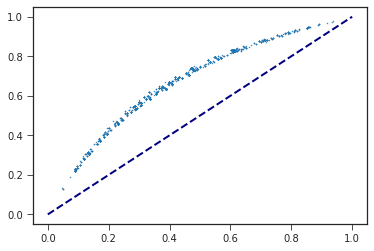

In [45]:
plt.scatter(reg.predict_proba(x_test[features])[:2000,1], reg_u.predict_proba(x_test[features_u])[:2000,1], s=0.2)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

This picture shows predicted probability by 2 models for saample of observations. On axis x there is standard model, while on axis y - with downsampling. As can be seen, downsampling actually caused systematically bigger probability of obtaining 1.

More fancy methods for resampling take a very long time to run. or actually can't run them on such big dataset.

In [46]:
# from sklearn.datasets import make_classification
# from imblearn.under_sampling import ClusterCentroids 

# cc = ClusterCentroids(random_state=42,sampling_strategy=0.5,n_jobs = -1)
# x_train_cl, y_train_cl = cc.fit_resample(x_train, y_train)

In [47]:
# from imblearn.under_sampling import TomekLinks

# cc = TomekLinks(n_jobs = -1)
# x_train_cl, y_train_cl = cc.fit_sample(x_train, y_train)

### KNN modeling

In [48]:
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn import neighbors

In [49]:
x_train_small = x_train.sample(n = 100000, random_state = 42)
y_train_small = y_train.sample(n = 100000, random_state = 42)

In [50]:
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_squared_error
# import random
# kf = KFold(n_splits=3, shuffle=True, random_state=random.randint(0,10000))

# scores = []
# ks = [5, 50, 100]
# no_features_to_include = 20
# features = list(minfos_df.head(no_features_to_include).column)

# for k in ks:
#     print('running for k: ', k)

#     r2_train = []
#     r2_test = []

#     for train, test in kf.split(x_train_small.index.values):

#         reg = neighbors.KNeighborsClassifier(k, n_jobs=-1, p=2)
#         reg.fit(x_train_small.iloc[train][features], y_train_small.iloc[train]['y'])

#         predsTrain = reg.predict_proba(x_train_small.iloc[train][features])
#         preds = reg.predict_proba(x_train_small.iloc[test][features])

#         r2_test.append(roc_auc_score(y_train_small.iloc[test].y, preds[:,1]))
#         r2_train.append(roc_auc_score(y_train_small.iloc[train].y, predsTrain[:,1]))

#     a = (k, np.mean(r2_test), np.mean(r2_train))
#     scores.append(a)  

# roc_scores_knn = pd.DataFrame(scores, columns = ['k', 'test', 'train'])
# roc_scores_knn.to_pickle('models_cache/roc_scores_knn_from_minfo.pkl')

In [51]:
roc_scores_knn = pd.read_pickle('models_cache/roc_scores_knn_from_minfo.pkl')

In [52]:
roc_scores_knn

,k,test,train
0,5,0.675893,0.695971
1,50,0.736777,0.744507
2,100,0.742325,0.748159


In [53]:
# predsTest = reg.predict_proba(x_test[features].iloc[:30000, :])
# # print("AUC for train set " , roc_auc_score(y_train.y, predsTrain[:,1]))
# print("AUC for test set " , roc_auc_score(y_test.iloc[:30000, :].y, predsTest[:,1]))

Auc for test set: 0.66155778766371